# SCS_3666_018 Applied Natural Language Processing - Final Project
### Predicting ECB rate changes based on speeches leading up to monetary policy rate decision meetings

## Tree Base Models

In [1]:
import os

# Set the current working directory
project_path = r"R:\HSPS\DDS\NLP Course\Final Project"
os.chdir(project_path)

# Verify the current working directory
print("Current working directory:", os.getcwd())

Current working directory: r:\HSPS\DDS\NLP Course\Final Project


In [2]:
import pandas as pd

In [3]:
# Read the Pickle file
loaded_data = pd.read_pickle(r'R:\HSPS\DDS\NLP Course\Final Project\ECB_Speeches_Normalized.pkl')

# Display the first few rows to verify
print(loaded_data.head())

   speech_id when_speech                     who  \
0       2748  1999-03-04    Willem F. Duisenberg   
1         80  1999-03-08         Christian Noyer   
2         81  1999-03-09  Tommaso Padoa-Schioppa   
3         82  1999-03-10  Eugenio Domingo Solans   
4         83  1999-03-12    Willem F. Duisenberg   

                                     what_title  \
0               Introductory statement with Q&A   
1               First experiences with the euro   
2  The euro: significance for Europe and beyond   
3              The euro as a new world currency   
4        The Eurosystem's strategy for the euro   

                                    what_frequencies what_language  \
0  {"euro":45,"question":33,"rate":30,"duisenberg...            EN   
1  {"monetary":64,"euro":51,"price":48,"policy":4...            EN   
2  {"euro":29,"currency":20,"monetary":15,"single...            EN   
3  {"euro":63,"currency":29,"area":23,"monetary":...            EN   
4  {"monetary":50,"stability":

## Logistic Regression Model

In [4]:
X = loaded_data['extracted_text']
y = loaded_data['Direction']

In [5]:
label_mapping = {
    'No Change': 0,
    'Increase': 1,
    'Decrease': 2
}

y= y.map(label_mapping).values
y

array([0, 2, 2, ..., 2, 2, 2], dtype=int64)

## Logistic Regression

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.utils import resample

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [20]:
# Handle class imbalance manually
train_data = pd.DataFrame({'text': X_train, 'label': y_train})

# Separate classes
class_0 = train_data[train_data['label'] == 0]
class_1 = train_data[train_data['label'] == 1]
class_2 = train_data[train_data['label'] == 2]

# Oversample minority classes to match the majority class
class_1_oversampled = resample(class_1, 
                               replace=True, 
                               n_samples=len(class_0), 
                               random_state=42)
class_2_oversampled = resample(class_2, 
                               replace=True, 
                               n_samples=len(class_0), 
                               random_state=42)

# Combine oversampled classes with majority class
train_data_balanced = pd.concat([class_0, class_1_oversampled, class_2_oversampled])

# Split back into features and labels
X_train_balanced = train_data_balanced['text']
y_train_balanced = train_data_balanced['label']

In [21]:
# Vectorize the balanced training data
X_train_balanced_tfidf = vectorizer.transform(X_train_balanced)

In [26]:
# Train Logistic Regression model with class weights
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_balanced_tfidf, y_train_balanced)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [27]:
# Make predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate model
print(classification_report(y_test, y_pred, target_names=label_mapping.keys()))

              precision    recall  f1-score   support

   No Change       0.93      0.84      0.88       578
    Increase       0.46      0.74      0.57        50
    Decrease       0.33      0.47      0.39        59

    accuracy                           0.80       687
   macro avg       0.57      0.68      0.61       687
weighted avg       0.84      0.80      0.81       687



## Gboosts

In [20]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

In [21]:
# Load and preprocess data
data = pd.read_pickle(r'R:\HSPS\DDS\NLP Course\Final Project\ECB_Speeches_Normalized.pkl')
X = data['extracted_text']
y = data['Direction']

# Map labels to numeric values
label_mapping = {'No Change': 0, 'Increase': 1, 'Decrease': 2}
y = y.map(label_mapping)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [22]:
# Train XGBoost model
xgb_model = XGBClassifier(
    scale_pos_weight=len(y_train) / y_train.value_counts().values,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_tfidf)

# Evaluate model
print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb, target_names=label_mapping.keys()))

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [06:54:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:
              precision    recall  f1-score   support

   No Change       0.88      0.99      0.93       578
    Increase       0.88      0.42      0.57        50
    Decrease       0.83      0.08      0.15        59

    accuracy                           0.87       687
   macro avg       0.86      0.50      0.55       687
weighted avg       0.87      0.87      0.84       687



In [24]:
import lightgbm

In [25]:
from lightgbm import LGBMClassifier

# Train LightGBM model
lgbm_model = LGBMClassifier(
    class_weight='balanced',
    random_state=42
)
lgbm_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_lgbm = lgbm_model.predict(X_test_tfidf)

# Evaluate model
print("LightGBM Results:")
print(classification_report(y_test, y_pred_lgbm, target_names=label_mapping.keys()))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 640943
[LightGBM] [Info] Number of data points in the train set: 2747, number of used features: 9893
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
LightGBM Results:
              precision    recall  f1-score   support

   No Change       0.89      0.98      0.93       578
    Increase       0.74      0.58      0.65        50
    Decrease       0.64      0.15      0.25        59

    accuracy                           0.88       687
   macro avg       0.76      0.57      0.61       687
weighted avg       0.86      0.88      0.85       687



In [27]:
import catboost

In [28]:
from catboost import CatBoostClassifier

# Train CatBoost model
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    class_weights=[1, len(y_train) / y_train.value_counts()[1], len(y_train) / y_train.value_counts()[2]],
    random_seed=42,
    verbose=100
)
catboost_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_catboost = catboost_model.predict(X_test_tfidf)

# Evaluate model
print("CatBoost Results:")
print(classification_report(y_test, y_pred_catboost, target_names=label_mapping.keys()))


0:	learn: 1.0862688	total: 1.8s	remaining: 14m 59s
100:	learn: 0.5561947	total: 2m 10s	remaining: 8m 36s
200:	learn: 0.2844287	total: 4m 23s	remaining: 6m 32s
300:	learn: 0.1812209	total: 6m 36s	remaining: 4m 22s
400:	learn: 0.1344899	total: 8m 48s	remaining: 2m 10s
499:	learn: 0.1072718	total: 11m 1s	remaining: 0us
CatBoost Results:
              precision    recall  f1-score   support

   No Change       0.91      0.92      0.91       578
    Increase       0.51      0.68      0.58        50
    Decrease       0.43      0.25      0.32        59

    accuracy                           0.84       687
   macro avg       0.61      0.62      0.60       687
weighted avg       0.84      0.84      0.84       687



In [29]:
from sklearn.ensemble import VotingClassifier

# Define the ensemble
voting_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('catboost', catboost_model)
    ],
    voting='soft'  # Use probabilities for better performance
)
voting_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_voting = voting_model.predict(X_test_tfidf)

# Evaluate ensemble model
print("Ensemble Voting Classifier Results:")
print(classification_report(y_test, y_pred_voting, target_names=label_mapping.keys()))


c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [07:09:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 640943
[LightGBM] [Info] Number of data points in the train set: 2747, number of used features: 9893
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
0:	learn: 1.0862688	total: 1.52s	remaining: 12m 37s
100:	learn: 0.5561947	total: 2m 8s	remaining: 8m 26s
200:	learn: 0.2844287	total: 4m 20s	remaining: 6m 27s
300:	learn: 0.1812209	total: 6m 32s	remaining: 4m 19s
400:	learn: 0.1344899	total: 8m 43s	remaining: 2m 9s
499:	learn: 0.1072718	total: 10m 53s	remaining: 0us
Ensemble Voting Classifier Results:
              precision    recall  f1-score   support

   No Change       0.89      0.98      0.93       578
    Increase       0.78      0.56      0.65        50
    Decrease       0.71      

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Load data
data = pd.read_pickle(r'R:\HSPS\DDS\NLP Course\Final Project\ECB_Speeches_Normalized.pkl')
X = data['extracted_text']
y = data['Direction']

# Map labels to numeric values
label_mapping = {'No Change': 0, 'Increase': 1, 'Decrease': 2}
y = y.map(label_mapping)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Combine training data for oversampling
train_data = pd.DataFrame({'text': X_train, 'label': y_train})

# Separate classes
class_0 = train_data[train_data['label'] == 0]
class_1 = train_data[train_data['label'] == 1]
class_2 = train_data[train_data['label'] == 2]

# Oversample minority classes
class_1_oversampled = resample(class_1, replace=True, n_samples=len(class_0), random_state=42)
class_2_oversampled = resample(class_2, replace=True, n_samples=len(class_0), random_state=42)

# Combine oversampled data with majority class
train_data_balanced = pd.concat([class_0, class_1_oversampled, class_2_oversampled])

# Split back into features and labels
X_train_balanced = train_data_balanced['text']
y_train_balanced = train_data_balanced['label']

# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 3), stop_words='english')
X_train_balanced_tfidf = vectorizer.fit_transform(X_train_balanced)
X_test_tfidf = vectorizer.transform(X_test)

# Define base models with class weights
xgb_model = XGBClassifier(
    scale_pos_weight=len(y_train_balanced) / y_train_balanced.value_counts().values,  # Adjust weights
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

lgbm_model = LGBMClassifier(
    class_weight='balanced',  # Auto-adjust weights
    random_state=42
)

catboost_model = CatBoostClassifier(
    class_weights=[1, len(y_train_balanced) / y_train_balanced.value_counts()[1], len(y_train_balanced) / y_train_balanced.value_counts()[2]],
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=False
)

# Ensemble Voting Classifier with weighted voting
voting_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('catboost', catboost_model)
    ],
    voting='soft',  # Use predicted probabilities
    weights=[1, 1, 2]  # Assign higher weight to CatBoost for minority classes
)

# Train the voting model
voting_model.fit(X_train_balanced_tfidf, y_train_balanced)

# Make predictions
y_pred_voting = voting_model.predict(X_test_tfidf)

# Evaluate ensemble model
print("Improved Ensemble Voting Classifier Results:")
print(classification_report(y_test, y_pred_voting, target_names=label_mapping.keys()))


c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:51:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.059684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021653
[LightGBM] [Info] Number of data points in the train set: 6930, number of used features: 19740
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Improved Ensemble Voting Classifier Results:
              precision    recall  f1-score   support

   No Change       0.90      0.97      0.93       578
    Increase       0.65      0.62      0.63        50
    Decrease       0.69      0.19      0.29        59

    accuracy                           0.87       687
   macro avg       0.74      0.59      0.62       687
weighted avg       0.86      0.87      0.85       687



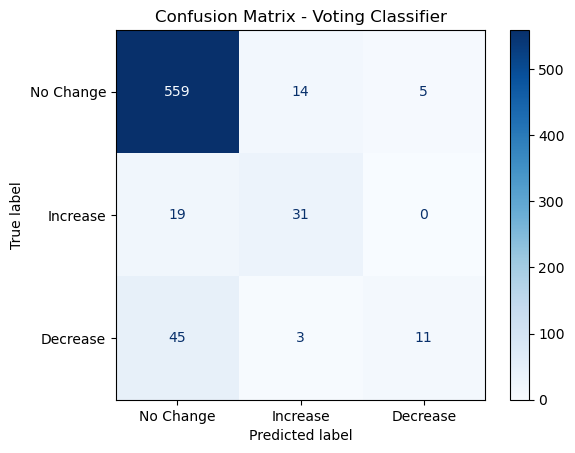

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Combine training data for manual oversampling
train_data = pd.DataFrame({'text': X_train, 'label': y_train})

# Separate classes
class_0 = train_data[train_data['label'] == 0]
class_1 = train_data[train_data['label'] == 1]
class_2 = train_data[train_data['label'] == 2]

# Oversample minority classes
class_1_oversampled = resample(class_1, replace=True, n_samples=len(class_0), random_state=42)
class_2_oversampled = resample(class_2, replace=True, n_samples=len(class_0), random_state=42)

# Combine oversampled data with the majority class
train_data_balanced = pd.concat([class_0, class_1_oversampled, class_2_oversampled])

# Split back into features and labels
X_train_balanced = train_data_balanced['text']
y_train_balanced = train_data_balanced['label']

# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 3), stop_words='english')
X_train_balanced_tfidf = vectorizer.fit_transform(X_train_balanced)
X_test_tfidf = vectorizer.transform(X_test)

# Define base models with class weights
xgb_model = XGBClassifier(
    scale_pos_weight=len(y_train_balanced) / y_train_balanced.value_counts().values,  # Adjust weights
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

lgbm_model = LGBMClassifier(
    class_weight='balanced',  # Auto-adjust weights
    random_state=42
)

catboost_model = CatBoostClassifier(
    class_weights=[1, len(y_train_balanced) / y_train_balanced.value_counts()[1], len(y_train_balanced) / y_train_balanced.value_counts()[2]],
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=False
)

# Ensemble Voting Classifier with weighted voting
voting_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('catboost', catboost_model)
    ],
    voting='soft',  # Use predicted probabilities
    weights=[1, 1, 2]  # Assign higher weight to CatBoost for minority classes
)

# Train the voting model
voting_model.fit(X_train_balanced_tfidf, y_train_balanced)

# Make predictions
y_pred_voting = voting_model.predict(X_test_tfidf)

# Evaluate ensemble model
print("Improved Ensemble Voting Classifier Results:")
print(classification_report(y_test, y_pred_voting, target_names=label_mapping.keys()))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_voting)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapping.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Voting Classifier")
plt.show()
